# Alaiz NSC benchmark

## Introduction
This script summarizes the overall results of the [Alaiz NSC benchmark](https://thewindvaneblog.com/numerical-site-calibration-benchmark-the-alaiz-case-b3767918d812).

## Load libraries

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
#import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
def readExcelToDf(simID):
    # load raw results into pandas
    
    import os
    directory = './outputs/'+simID
    mastName = []
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx") and simID == filename.split('_')[0]:
            filename = filename.replace(simID+'_', '').replace('.xlsx', '')
            mastName.append(filename)

    list_df = []
    # loop on masts
    for k in mastName:

        stab = ['u', 'n', 's']
        filename = './outputs/'+simID+'/'+simID+'_'+k+'.xlsx'
        # loop on stabilities
        for j in range(3):
            
            sheets = ['wind_speed', 'turbulence_intensity']
            variables = dict.fromkeys(sheets)
            for sheet in sheets:
                # read wind speed / turbulence
                try:
                    df_excel = pd.read_excel(open(filename, 'rb'), sheet_name=sheet, usecols="A:K", nrows=6, skiprows=j*8, index_col=None, header=None)
                except:
                    print('Error reading excel:', filename, sheet)
                    return
                sectors = list(df_excel.iloc[0,1:])

                list_df_sheet = []
                # loop on sectors
                for i in range(0, len(sectors)):
                    df_tmp = df_excel.iloc[1:,:].copy()
                    df_tmp['ID'] = simID
                    df_tmp['mast'] = k
                    #df_tmp['mast'] = re.sub('(A.)_SC.', r'\1', k)
                    try:
                        df_tmp['Sector'] = round(sectors[i])
                    except ValueError:
                        print('Error reading excel:', filename, sheet)
                        return
                    df_tmp['Stability'] = stab[j]
                    df_tmp = df_tmp.rename(columns={0:"z", i+1: sheet})[['ID', 'mast', "Sector", "Stability", "z", sheet]]
                    df_tmp.z = df_tmp.z.astype(float)
                    
                    list_df_sheet.append(df_tmp)

                variables[sheet] = pd.concat([a for a in list_df_sheet], axis=0)
                variables[sheet].set_index(['ID', 'mast', 'Sector', 'Stability', 'z'], inplace=True)

            try:
                df_sim = pd.concat([variables[sheet] for sheet in sheets], axis=1)
            except:
                print('Error merging dataframes.')
                return
            list_df.append(df_sim)
    
    return list_df

## Results

### Participants

In [4]:
# Read file with simulation descriptions
sims = pd.read_csv('outputs/alaizNSC_sims.csv', na_filter=False)
sims = sims[~sims.Remarks.isin(['test'])]

n_sim = len(sims)
display(sims)

,ID,Participant,Software Name,Model Name,Number of sectors simulated,Stability modelling,Forest model,Input,"dx, dy [m]",dz [m],L [km],Use time series to transfer wind speed from MP5,Remarks,Label
0,wt168,Huaneng Clean Energy Technology Research Insti...,WT,RANS k-l,,Yes,,Default,,,,,Preliminary,
1,wt324,"SPIC Energy Technology & Engineering Co., Ltd",WT+Mesoscale,RANS k-l,"Ten 10° sectors: 340, …, 20° and 150, …, 190°","Yes (class 1, 2, 6)",,Default,,,11,,Preliminary,
2,wt110,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",,SRTM90m,30,6,12,Yes,Preliminary,
3,wt363,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",,Default,30,6,12,Yes,Preliminary,
4,rans233,N/A,N/A,RANS,,,,Default,,,,,Preliminary,
5,wt194,"Guohua Energy Investment Co.,Ltd",WT,RANS k-l,,Yes,,Default,,,,,Preliminary,
6,wasp949,EDF Renouvelables,Wasp,Linear,"Ten 10° sectors: 340, …, 20° and 150, …, 190°",Calibration using MP5 profile.,Calibration using MP5 profile.,plus tree height for displacement height calcu...,,,,Yes，LT,Preliminary,
7,wt949,EDF Renouvelables,WT,RANS k-l,"Ten 10° sectors: 340, …, 20° and 150, …, 190°","Yes (class 0, 2, 4)",Default WT,Default,10,4,4,Yes，LT,Preliminary,
8,les122,N/A,N/A,LES,11 gestrophic wind directions,via the initial temperature profile and a time...,No,Default,40,20,,Binning based on simulated unsteady wind at MP5,Preliminary,
9,les122a,N/A,N/A,LES,11 gestrophic wind directions,via the initial temperature profile and a time...,No,Default,20,10,,Binning based on simulated unsteady wind at MP5,Revised,


### Load results

In [5]:
list_df = []

simIDs = sims.ID.values

for simID in simIDs:
    list_df += readExcelToDf(simID)

# concatenate all dataframes.
df_sims = pd.concat([a for a in list_df], axis=0)

### Test with xarray Dataset

In [6]:
# convert to xarray dataset.
ds_sims = xr.Dataset.from_dataframe(df_sims)

In [7]:
# Sector 20 missing in les122a 
#ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=20, Stability='n')] = ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=19, Stability='n')]
#ds_sims["turbulence_intensity"].loc[dict(ID='les122a', Sector=20, Stability='n')] = ds_sims["wind_speed"].loc[dict(ID='les122a', Sector=19, Stability='n')]

In [8]:
# define simulation type
simtype = []
for simID in ds_sims.ID.values:
    simtype.append('rans' if ('wt' in simID or 'rans' in simID or 'meteodyn' in simID) else 'les' if 'les' in simID else 'linear' if 'wasp' in simID else '')
ds_sims.coords["simtype"] = ("ID", simtype)

### Flow correction factor (FCF)

In [9]:
ds_sims["flow_correction_factor"] = ds_sims["wind_speed"].copy()
for simID in ds_sims.ID.values:
    print('Processing results of', simID, 'with', df_sims.loc[simID].index.unique('mast').to_list())
    if 'MP5_SC1' in df_sims.loc[simID].index.unique('mast') and 'MP5_SC2' in df_sims.loc[simID].index.unique('mast'):
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A1', 'A2', 'A3', 'MP5_SC2'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A4', 'A5', 'A6', 'MP5_SC1'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC1', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] = 0.5*(ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5_SC1')] + ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5_SC2')])
    elif simID in ['wt110', 'wt363']:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
    else:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID)] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
        
ds_sims = ds_sims.sel(mast=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5'])

Processing results of les122 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of les122a with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans135a with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of rans135aLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans135b with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of rans135bLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans135c with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of rans135cLT with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans211 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5']
Processing results of rans233 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of rans270 with ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5_SC1', 'MP5_SC2']
Processing results of wasp949 with ['A1', 'A2

In [10]:
ds_sims.sel(ID='les122', mast='MP5')

<xarray.Dataset>
Dimensions:                 (Sector: 10, Stability: 3, z: 5)
Coordinates:
    ID                      <U6 'les122'
    mast                    <U3 'MP5'
  * Sector                  (Sector) int64 1 2 3 16 17 18 19 20 35 36
  * Stability               (Stability) object 'n' 's' 'u'
  * z                       (z) float64 40.0 78.0 90.0 102.0 118.0
    simtype                 <U6 'les'
Data variables:
    wind_speed              (Sector, Stability, z) float64 9.752 10.48 ... 9.599
    turbulence_intensity    (Sector, Stability, z) float64 0.08447 ... 0.08471
    flow_correction_factor  (Sector, Stability, z) float64 0.9184 0.987 ... 1.0

### Load observation data

In [11]:
ds_all = ds_sims.copy()
ds_all["Sector"] = ds_sims.Sector.astype(str)

fnList = ['./results/'+a for a in ['A1_SC2.nc', 'A2_SC2.nc', 'A3_SC2.nc', 'A4_SC1.nc', 'A5_SC1.nc', 'A6_SC1.nc']] + ['./inputs/'+a for a in ['MP5_LT.nc']]
obs = dict.fromkeys([fn[0:2] for fn in fnList])
for fn in fnList:
    mast = fn.split('/')[2].split('_')[0]
    obs[mast] = xr.open_dataset(fn)
    obs[mast] = obs[mast].assign_coords(ID='obs')
    obs[mast] = obs[mast].expand_dims('ID')
    obs[mast].coords["simtype"] = ("ID", ['obs'])
    obs[mast] = obs[mast].assign_coords(mast=mast)
    obs[mast] = obs[mast].expand_dims('mast')
    ds_all = xr.merge([ds_all, obs[mast]])

northSectors = ['1', '2', '3', '35', '36']
southSectors = ['16', '17', '18', '19', '20']
norsSectors = northSectors + southSectors
nors = []
for sec in ds_all.coords["Sector"]:
    nors.append('North' if sec in northSectors else 'South' if sec in southSectors else '')
ds_all.coords["nors"] = ("Sector", nors)

# standardize format after merge
ds_all["Sector"] = ds_all.Sector.astype(int)
ds_all = ds_all.sortby(ds_all.Sector, ascending=True)
ds_all["Sector"] = ds_all.Sector.astype(str)

ds_all['samples'] = ds_all.sel(ID='obs')['samples']

#ds_all["samples"].loc[dict(mast='MP5_SC1')] = ds_all["samples"].loc[dict(mast='MP5')]
#ds_all["samples"].loc[dict(mast='MP5_SC2')] = ds_all["samples"].loc[dict(mast='MP5')]
#ds_all["flow_correction_factor"].loc[dict(mast='MP5_SC1')] = ds_all["flow_correction_factor"].loc[dict(mast='MP5')]
#ds_all["flow_correction_factor"].loc[dict(mast='MP5_SC2')] = ds_all["flow_correction_factor"].loc[dict(mast='MP5')]

ds_all.sel(ID='obs')['samples'].to_dataframe().reset_index().groupby(['nors', 'Stability']).samples.sum()

nors   Stability
       n             5732.0
       s            10027.0
       u            23945.0
North  n             5711.0
       s            10305.0
       u            43270.0
South  n             5440.0
       s            13359.0
       u            12343.0
Name: samples, dtype: float64

## Sector-wise averaged

In [12]:
'''
# Calculate the weights by grouping by North/South.
weights = ds_all.samples.groupby('nors') /  ds_all.samples.groupby('nors').sum(dim='Sector')

# Test that the sum of the weights for each North/South is 0.0
np.testing.assert_allclose(weights.groupby('nors').sum(dim='Sector').values, np.ones((9,3,3)))

# Calculate the weighted average
ds_all['fcfns'] = (ds_all.flow_correction_factor * weights).groupby('nors').sum(dim='Sector')
'''

"\n# Calculate the weights by grouping by North/South.\nweights = ds_all.samples.groupby('nors') /  ds_all.samples.groupby('nors').sum(dim='Sector')\n\n# Test that the sum of the weights for each North/South is 0.0\nnp.testing.assert_allclose(weights.groupby('nors').sum(dim='Sector').values, np.ones((9,3,3)))\n\n# Calculate the weighted average\nds_all['fcfns'] = (ds_all.flow_correction_factor * weights).groupby('nors').sum(dim='Sector')\n"

## Bias calculation

In [13]:
'''
var_fcf = 'flow_correction_factor'
ds_all['error'] = abs(ds_all[var_fcf] - ds_all[var_fcf].sel(ID='obs'))/ds_all[var_fcf].sel(ID='obs')
ds_all['bias'] = (ds_all[var_fcf] - ds_all[var_fcf].sel(ID='obs'))/ds_all[var_fcf].sel(ID='obs')
'''

ds_all['error'] = abs(ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')
ds_all['bias'] = (ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')

ds_error = ds_all.sel(Sector=norsSectors, mast=['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])

### Back to pandas Dateframe for plotting

In [14]:
df_error = ds_error.sel(z=118)[['error', 'bias', 'samples']].to_dataframe()
df_error = df_error.drop(columns=['z'])
df_error = df_error.reset_index()
df_error = df_error[df_error.ID != 'obs']
df_error = df_error[df_error.error.notna()]

df_error = df_error.replace({'Stability': 'u'}, 'Unstable')
df_error = df_error.replace({'Stability': 'n'}, 'Neutral')
df_error = df_error.replace({'Stability': 's'}, 'Stable')

# focus on A1-A6 masts
df_error.mast.value_counts()

A2    539
A1    539
A3    539
A5    537
A4    536
A6    536
Name: mast, dtype: int64

In [15]:
# verification
gp = df_error.groupby(['ID', 'Stability', 'Sector', 'mast'])
df_error['errbis'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['errbis'] = gp.errbis.transform('sum')
print((df_error.errbis - df_error.error).sum()<1e-5)

# weighted mean error
gp = df_error.groupby(['ID'])
df_error['error_ID'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_ID'] = gp.error_ID.transform('sum')

gp = df_error.groupby(['ID'])
df_error['bias_ID'] = df_error.bias * df_error.samples / gp.samples.transform('sum')
df_error['bias_ID'] = gp.bias_ID.transform('sum')

gp = df_error.groupby(['ID', 'mast'])
df_error['error_mast'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_mast'] = gp.error_mast.transform('sum')

gp = df_error.groupby(['ID', 'Stability', 'nors'])
df_error['error_ns_wt'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_ns_wt'] = gp.error_ns_wt.transform('sum')

gp = df_error.groupby(['ID', 'Stability', 'nors'])
df_error['bias_ns_wt'] = df_error.bias * df_error.samples / gp.samples.transform('sum')
df_error['bias_ns_wt'] = gp.bias_ns_wt.transform('sum')

True


### Plot

In [16]:
# define sort order
custom_dict = {'linear': 1, 'rans': 2, 'les': 3, 'obs' : 0, 'u':0,'n':1,'s':2, 'Unstable':0,'Neutral':1,'Stable':2, '1':1, '2':2, '3':3, '35':35, '36':36, '16':16, '17':17, '18':18, '19':19, '20':20}

            ID     error  error_ID   bias_ID
0     rans135c  0.055831  0.051068 -0.031777
1   rans135cLT  0.053964  0.051653 -0.035791
2     rans135a  0.062452  0.053608 -0.026769
3        wt949  0.054905  0.054612 -0.029381
4   rans135aLT  0.060832  0.054631 -0.030916
5     rans135b  0.063143  0.054751 -0.027559
6   rans135bLT  0.061963  0.055935 -0.031453
7        wt110  0.058849  0.057282 -0.024756
8        wt363  0.059316  0.057545 -0.023700
9      wasp949  0.056420  0.057759 -0.041508
10     rans270  0.060756  0.058810 -0.030704
11       wt168  0.062624  0.060015 -0.026204
12       wt194  0.072976  0.063646 -0.026270
13     rans211  0.060102  0.065083 -0.042379
14     rans233  0.071453  0.066569 -0.032053
15       wt324  0.068823  0.067056 -0.025124
16     les122a  0.092969  0.077020  0.004259
17      les122  0.103054  0.089644  0.000982


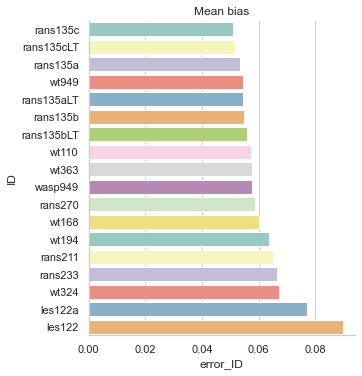

In [17]:
df_plot = df_error.groupby(['ID']).mean().sort_values(by=['error_ID']).reset_index()[['ID', 'error', 'error_ID', 'bias_ID']]
print(df_plot)

sns.set(style="whitegrid")
g = sns.catplot(x="error_ID", y="ID", kind="bar", data=df_plot, palette='Set3')
plt.title("Mean bias")
saved_sort_order = dict((v,k) for k,v in df_plot.ID.to_dict().items())

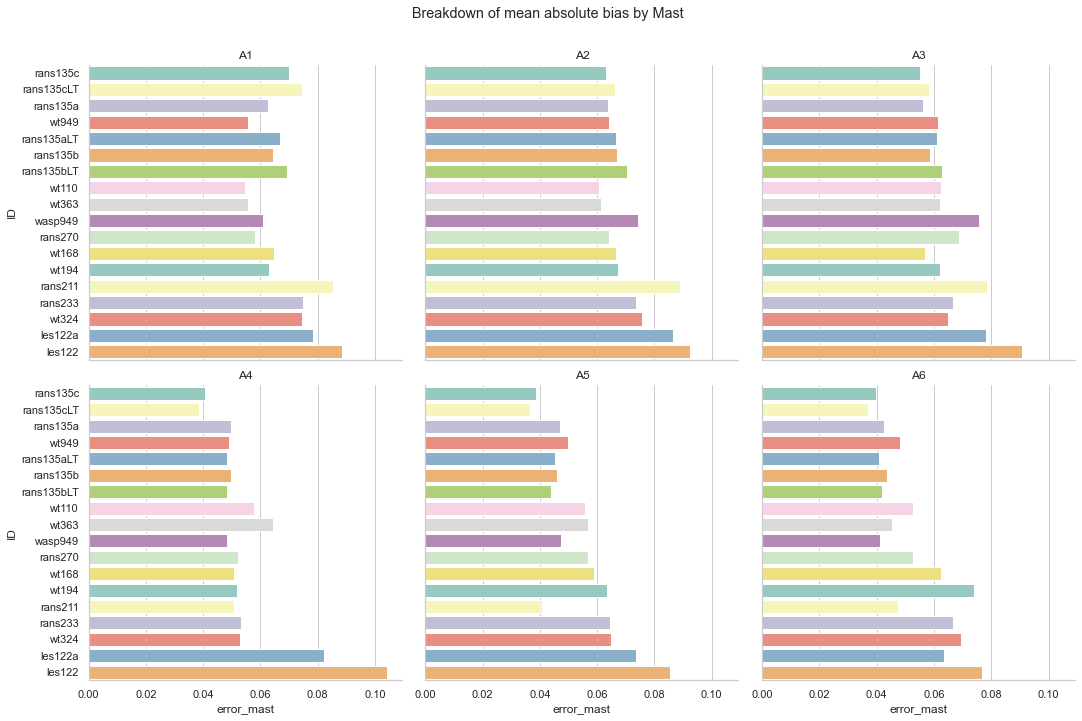

In [18]:
df_plot = df_error.groupby(['ID', 'mast']).mean().reset_index()
df_plot.sort_values(by=['mast', 'ID'], key=lambda x: x.map(saved_sort_order), inplace=True)

g = sns.catplot(x="error_mast", y="ID", col='mast', col_wrap=3, kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean absolute bias by Mast")
g.fig.subplots_adjust(top=.9)
g.set_titles('{col_name}')

In [19]:
df_error.groupby(['nors', 'Stability'])['samples'].sum()

nors   Stability
North  Neutral       61350.0
       Stable        96480.0
       Unstable     348694.0
South  Neutral       55236.0
       Stable       149256.0
       Unstable     127332.0
Name: samples, dtype: float64

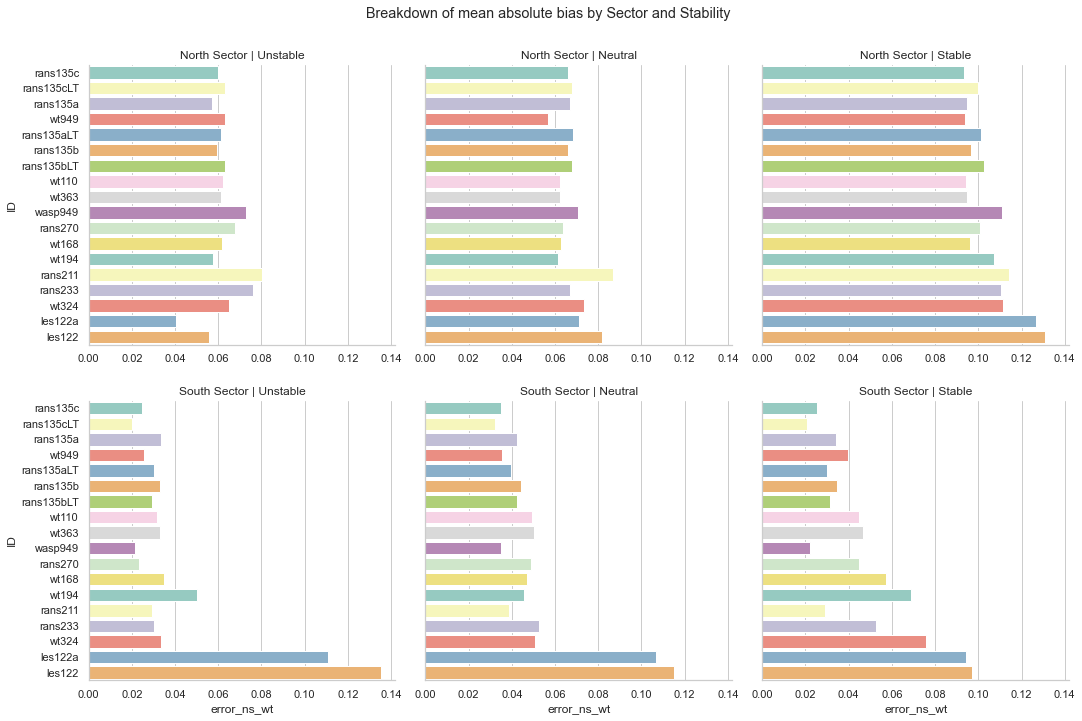

In [20]:
custom_dict.update(saved_sort_order)

df_plot = df_error.groupby(['nors', 'Stability', 'ID']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error_ns_wt", y="ID", col='Stability', row='nors', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean absolute bias by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

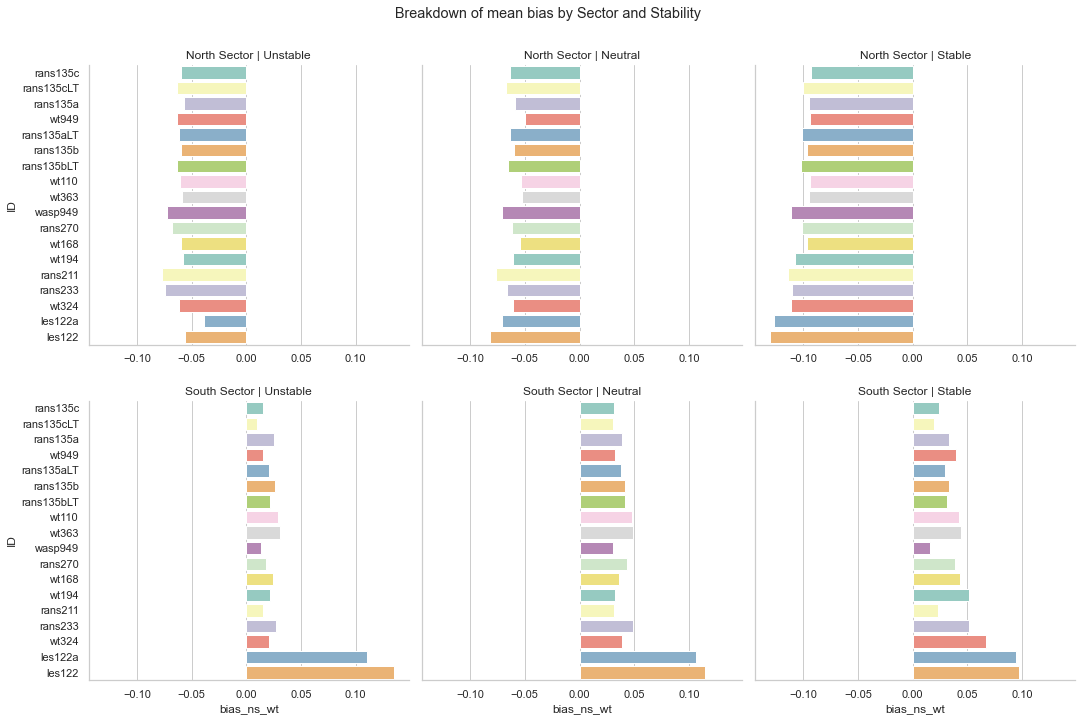

In [21]:
custom_dict.update(saved_sort_order)

df_plot = df_error.groupby(['nors', 'Stability', 'ID']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="bias_ns_wt", y="ID", col='Stability', row='nors', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean bias by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

In [22]:
df_error.groupby(['nors', 'Stability'])['samples'].sum()

nors   Stability
North  Neutral       61350.0
       Stable        96480.0
       Unstable     348694.0
South  Neutral       55236.0
       Stable       149256.0
       Unstable     127332.0
Name: samples, dtype: float64

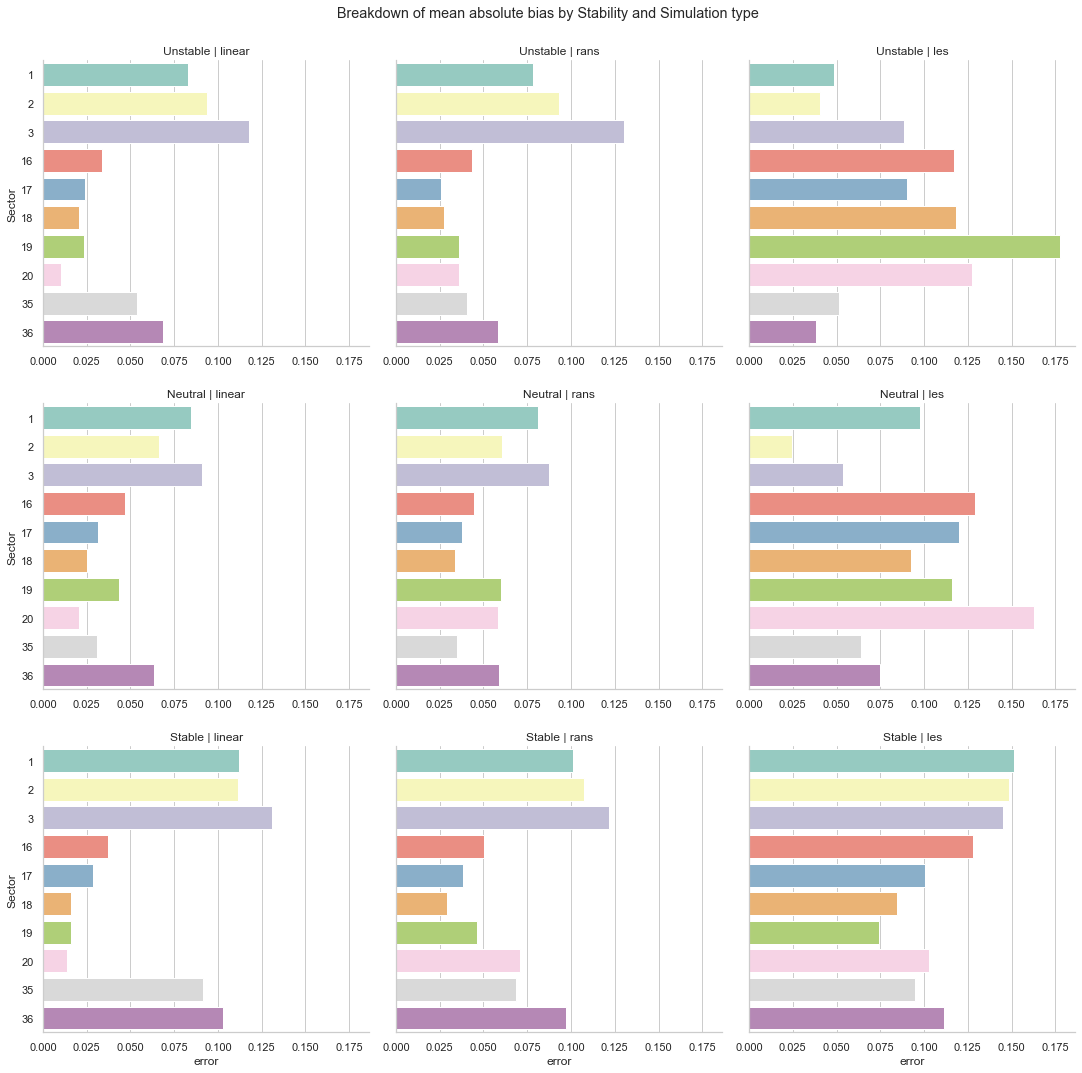

In [23]:
df_plot = df_error.groupby(['simtype', 'Sector', 'Stability']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Sector', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error", y="Sector", col='simtype', row='Stability', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean absolute bias by Stability and Simulation type")
g.fig.subplots_adjust(top=.93)
g.set_titles('{row_name}' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

## FCF profiles

In [25]:
#df_fcf = ds_all['flow_correction_factor'].to_dataframe()
df_fcf = ds_all[['samples', 'turbulence_intensity', 'flow_correction_factor']].to_dataframe()
df_fcf = df_fcf.reset_index()
df_fcf = df_fcf[df_fcf.flow_correction_factor.notna()]
df_fcf = df_fcf[df_fcf['nors']!='']

# Define MP5_SC5 as MP5.
print(df_fcf.mast.unique())
#df_fcf = df_fcf.replace({'mast': 'MP5_SC2'}, 'MP5')

#df_fcf = df_fcf[df_fcf.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5'])]
#df_fcf = df_fcf[df_fcf.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])]

df_fcf = df_fcf.replace({'Stability': 'u'}, 'Unstable')
df_fcf = df_fcf.replace({'Stability': 'n'}, 'Neutral')
df_fcf = df_fcf.replace({'Stability': 's'}, 'Stable')

df_fcf.mast.value_counts()

['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'MP5']


A2     2842
A4     2833
A1     2812
A3     2812
A5     2805
A6     2803
MP5    2722
Name: mast, dtype: int64

In [26]:
# verification
gp = df_fcf.groupby(['ID', 'mast', 'Sector', 'Stability', 'z'])
df_fcf['fcf_bis'] = df_fcf.flow_correction_factor * df_fcf.samples / gp.samples.transform('sum')
df_fcf['fcf_bis'] = gp.fcf_bis.transform('sum')
(df_fcf.fcf_bis - df_fcf.flow_correction_factor).describe()

# weighted mean error
gp = df_fcf.groupby(['ID', 'mast', 'nors', 'Stability', 'z'])
df_fcf['fcf_ns'] = df_fcf.flow_correction_factor * df_fcf.samples / gp.samples.transform('sum')
df_fcf['fcf_ns'] = gp.fcf_ns.transform('sum')

### Plot

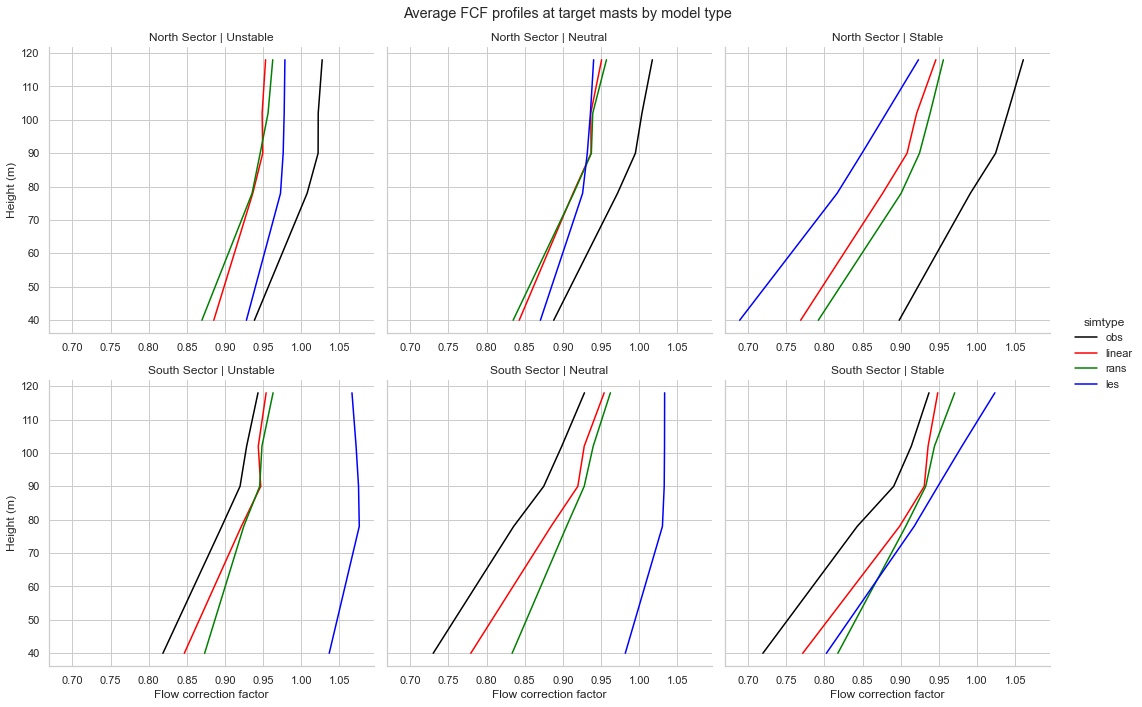

In [27]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['black', 'red', 'green', 'blue']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf[df_fcf.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])].groupby(['simtype', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='nors', hue='simtype', kind='line', palette = customPalette)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Average FCF profiles at target masts by model type")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")

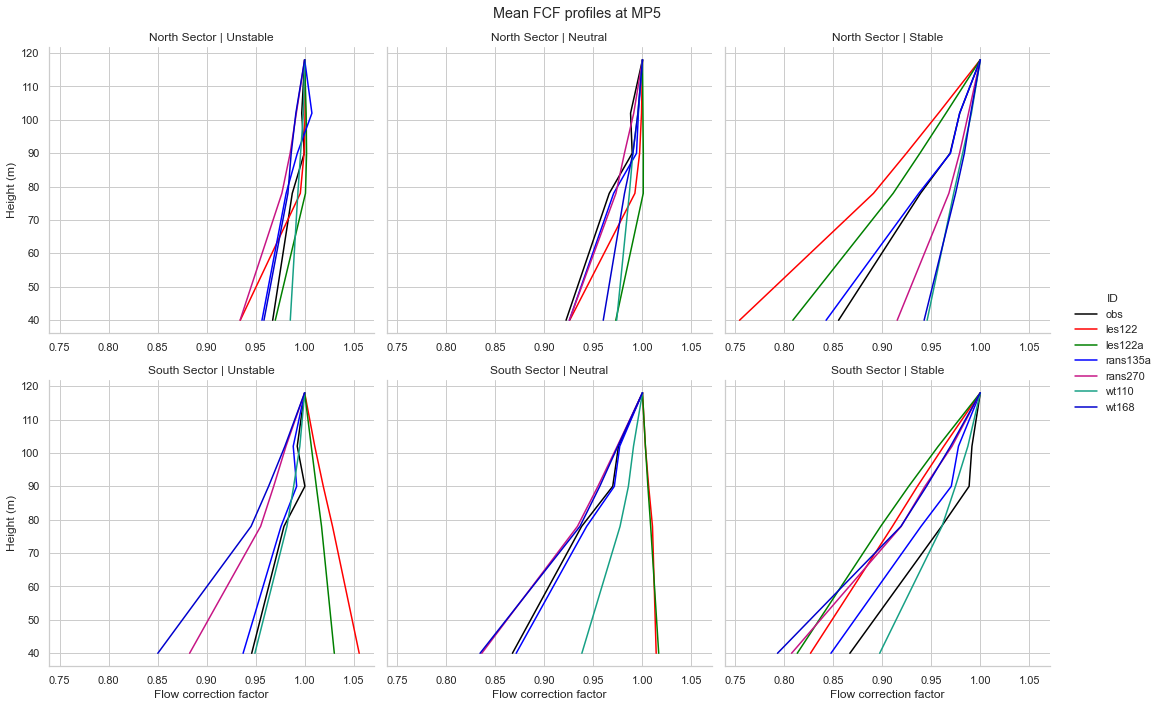

In [28]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['black', 'red', 'green', 'blue']
colors += ['mediumvioletred', '#16A085', 'mediumblue','#D4AC0D','firebrick','#808B96','#5DADE2','C2','#A569BD',
               '#641E16', '#A93226','#D98880','#ABB2B9','C0','C1','C3','C4','C5','C6','C7']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

#df_plot = df_fcf[(df_fcf.ID.isin(['obs', 'wasp949', 'wt949', 'rans211', 'rans135aLT', 'rans270']))&(df_fcf.mast=='MP5')].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot = df_fcf[df_fcf.ID.isin(['obs', 'rans135a', 'les122', 'les122a', 'rans270', 'wt110', 'wt168'])]
df_plot = df_plot[df_plot.mast.isin(['MP5', 'MP5_SC1'])].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2}
df_plot.sort_values(by=['ID', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Mean FCF profiles at MP5")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")

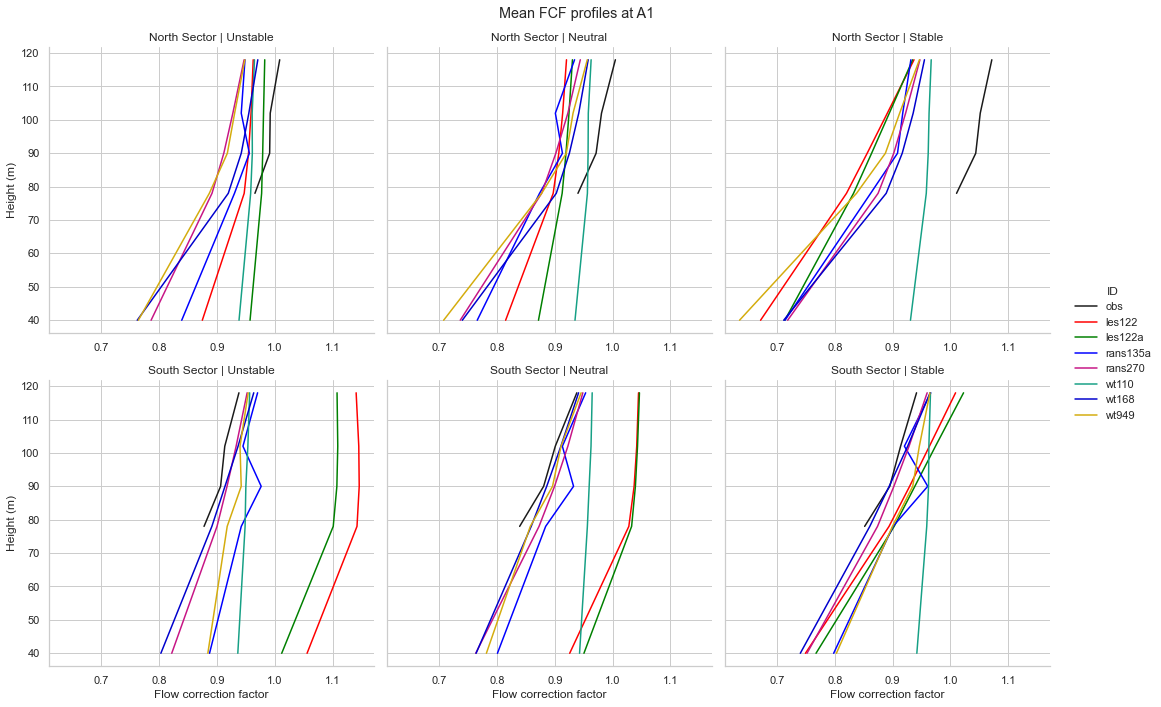

In [29]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['k', 'red', 'green', 'blue']
colors += ['mediumvioletred', '#16A085', 'mediumblue','#D4AC0D','firebrick','#808B96','#5DADE2','C2','#A569BD',
               '#641E16', '#A93226','#D98880','#ABB2B9','C0','C1','C3','C4','C5','C6','C7']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf[df_fcf.ID.isin(['obs', 'rans135a', 'les122', 'les122a', 'rans270', 'wt168', 'wt110', 'wt949'])]
#df_plot = df_fcf[df_fcf.ID.isin(['obs', 'wt168'])]
df_plot = df_plot[(df_plot.mast.isin(['A1']))].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2}
df_plot.sort_values(by=['ID', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="fcf_ns", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Mean FCF profiles at A1")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.set(xlim=(0.75,1.00))
#g.savefig("facet_plot.png")

In [30]:
df_error[(df_error.ID=='wt110') & (df_error.mast=='A1') & (df_error.nors=='South') & (df_error.Stability=='Neutral')]

,ID,Sector,Stability,mast,error,bias,samples,simtype,nors,errbis,error_ID,bias_ID,error_mast,error_ns_wt,bias_ns_wt
2430,wt110,16,Neutral,A1,0.024697,-0.024697,85.0,rans,South,0.024697,0.057282,-0.024756,0.054651,0.049507,0.047623
2448,wt110,17,Neutral,A1,0.074003,0.074003,121.0,rans,South,0.074003,0.057282,-0.024756,0.054651,0.049507,0.047623
2466,wt110,18,Neutral,A1,0.029426,0.029426,124.0,rans,South,0.029426,0.057282,-0.024756,0.054651,0.049507,0.047623
2484,wt110,19,Neutral,A1,0.002776,0.002776,64.0,rans,South,0.002776,0.057282,-0.024756,0.054651,0.049507,0.047623
2502,wt110,20,Neutral,A1,0.056873,0.056873,21.0,rans,South,0.056873,0.057282,-0.024756,0.054651,0.049507,0.047623


In [31]:
df_error[(df_error.ID=='wt949') & (df_error.mast=='A1') & (df_error.nors=='South') & (df_error.Stability=='Neutral')]

,ID,Sector,Stability,mast,error,bias,samples,simtype,nors,errbis,error_ID,bias_ID,error_mast,error_ns_wt,bias_ns_wt
3330,wt949,16,Neutral,A1,0.016191,-0.016191,85.0,rans,South,0.016191,0.054612,-0.029381,0.05554,0.035471,0.032694
3348,wt949,17,Neutral,A1,0.006559,-0.006559,121.0,rans,South,0.006559,0.054612,-0.029381,0.05554,0.035471,0.032694
3366,wt949,18,Neutral,A1,0.004078,0.004078,124.0,rans,South,0.004078,0.054612,-0.029381,0.05554,0.035471,0.032694
3384,wt949,19,Neutral,A1,0.063353,0.063353,64.0,rans,South,0.063353,0.054612,-0.029381,0.05554,0.035471,0.032694
3402,wt949,20,Neutral,A1,0.049398,0.049398,21.0,rans,South,0.049398,0.054612,-0.029381,0.05554,0.035471,0.032694


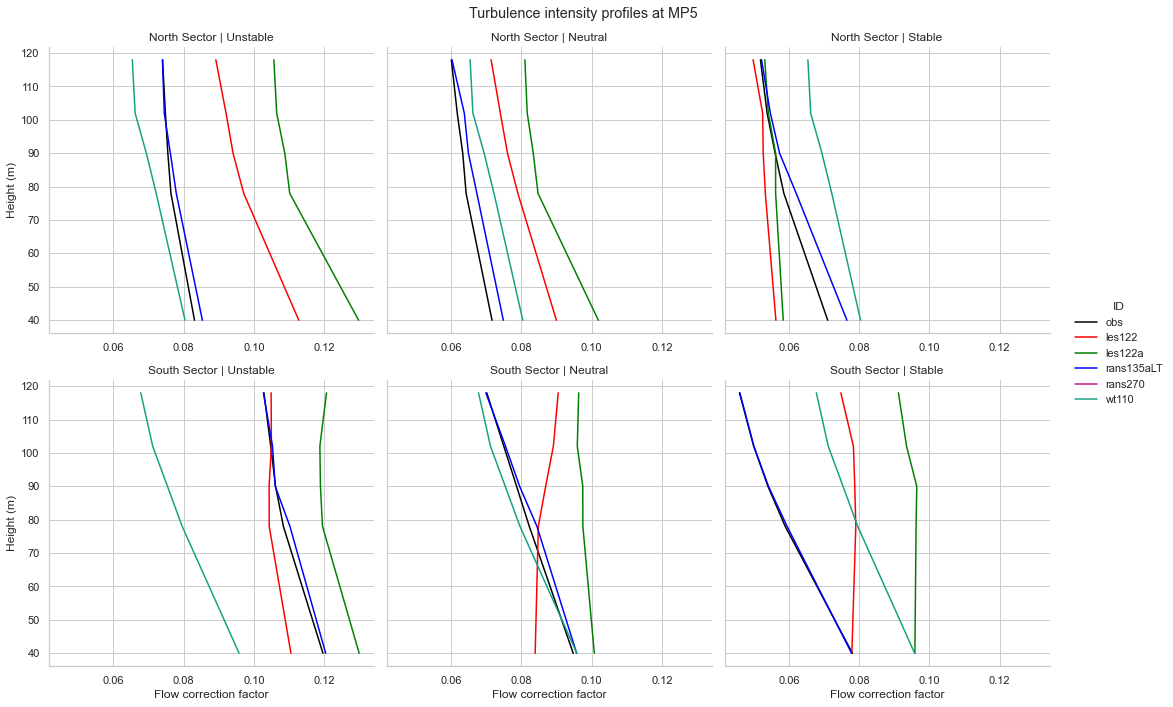

In [32]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['black', 'red', 'green', 'blue']
colors += ['mediumvioletred', '#16A085', 'mediumblue','#D4AC0D','firebrick','#808B96','#5DADE2','C2','#A569BD',
               '#641E16', '#A93226','#D98880','#ABB2B9','C0','C1','C3','C4','C5','C6','C7']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

#df_plot = df_fcf[(df_fcf.ID.isin(['obs', 'wasp949', 'wt949', 'rans211', 'rans135aLT', 'rans270']))&(df_fcf.mast=='MP5')].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot = df_fcf[df_fcf.ID.isin(['obs', 'rans135aLT', 'les122', 'les122a', 'rans270', 'wt110'])]
df_plot = df_plot[df_plot.mast.isin(['MP5', 'MP5_LT'])].groupby(['ID', 'z', 'Stability', 'nors']).mean().reset_index()
custom_dict = {'obs' : 0, 'Unstable':0,'Neutral':1,'Stable':2}
df_plot.sort_values(by=['ID', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

#g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, style='ID')
                #, dashes=[(2,0), (4,2), (2,0), (6,4), (1,1)])
g = sns.relplot(data=df_plot, x="turbulence_intensity", y="z", sort=False, col='Stability', row='nors', hue='ID', kind='line', palette=customPalette, dashes=True)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Turbulence intensity profiles at MP5")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")